# XMM-LSS master catalogue
## Preparation of UKIRT Infrared Deep Sky Survey / Deep Extragalactic Survey (UKIDSS/DXS)

The catalogue comes from `dmu0_UKIDSS-DXS_DR10plus`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in apertude 3 (2 arcsec).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

The magnitudes are “*Vega like*”.  The AB offsets are given by Hewett *et al.*
(2016):

| Band | AB offset |
|------|-----------|
| J    | 0.938     |
| H    | 1.379     |
| K    | 1.900     |

A query to the UKIDSS database with 242.9+55.071 position returns a list of images taken between 2007 and 2009. Let's take 2008 for the epoch.


In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
91cdb7b (Fri Oct 20 11:48:11 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "dxs_ra"
DEC_COL = "dxs_dec"

## I - Column selection

In [6]:
imported_columns = OrderedDict({
        'sourceid': 'dxs_id',
        'RA': 'dxs_ra',
        'Dec': 'dxs_dec',
        'JAPERMAG3': 'm_ap_ukidss_j',
        'JAPERMAG3ERR': 'merr_ap_ukidss_j',
        'JKRONMAG': 'm_ukidss_j',
        'JKRONMAGERR': 'merr_ukidss_j',
        'KAPERMAG3': 'm_ap_ukidss_k',
        'KAPERMAG3ERR': 'merr_ap_ukidss_k',
        'KKRONMAG': 'm_ukidss_k',
         'KKRONMAGERR': 'merr_ukidss_k',
         'PSTAR': 'dxs_stellarity'
    })

catalogue = Table.read(
    "../../dmu0/dmu0_UKIDSS-DXS_DR10plus/data/UKIDSS-DR10plus_XMM-LSS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2008

# Clean table metadata
catalogue.meta = None

In [7]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # DXS uses a huge negative number for missing values
        catalogue[col][catalogue[col] < -100] = np.nan
        catalogue[errcol][catalogue[errcol] < -100] = np.nan
        
        # Vega to AB correction
        if col.endswith('j'):
            catalogue[col] += 0.938
        elif col.endswith('k'):
            catalogue[col] += 1.900
        else:
            print("{} column has wrong band...".format(col))

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [8]:
catalogue[:10].show_in_notebook()

idx,dxs_id,dxs_ra,dxs_dec,m_ap_ukidss_j,merr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,dxs_stellarity,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k
,,degrees,degrees,,,,,,,,,,,,,,,,,,,
0,446679347818,34.91798053,-2.55580229131,nan,nan,nan,nan,19.3136,0.0121872,19.3094,0.0128282,0.05,nan,nan,nan,nan,False,68.321,0.766893,68.5892,0.810394,False
1,446679347819,34.9572533827,-2.55559991421,nan,nan,nan,nan,20.5912,0.0318615,20.5896,0.0431118,0.05,nan,nan,nan,nan,False,21.0625,0.618088,21.0937,0.837575,False
2,446679347820,34.9573000353,-2.55565754591,nan,nan,nan,nan,21.0413,0.0462253,21.5479,0.14819,0.05,nan,nan,nan,nan,False,13.9151,0.592437,8.72648,1.19106,False
3,446679347822,34.8941725314,-2.55479271224,nan,nan,nan,nan,21.5662,0.0725572,21.7644,0.075405,0.9,nan,nan,nan,nan,False,8.58042,0.573409,7.14912,0.496511,False
4,446679347824,34.799567038,-2.5547325608,nan,nan,nan,nan,20.9516,0.0430978,21.0156,0.0504331,0.05,nan,nan,nan,nan,False,15.1132,0.599912,14.2479,0.661823,False
5,446679347825,34.7684661738,-2.55457775799,nan,nan,nan,nan,21.6057,0.0754797,22.0474,0.0717686,0.05,nan,nan,nan,nan,False,8.27444,0.575233,5.50836,0.36411,False
6,446679347826,34.7971903201,-2.55448072181,nan,nan,nan,nan,21.3026,0.0580236,21.3265,0.0887633,0.05,nan,nan,nan,nan,False,10.9387,0.584581,10.7007,0.874826,False
7,446679347827,34.8328363286,-2.55434509318,nan,nan,nan,nan,21.6178,0.0760388,21.8534,0.0792593,0.9,nan,nan,nan,nan,False,8.1826,0.573063,6.58601,0.480782,False
8,446679347828,34.9599928558,-2.55436551507,nan,nan,nan,nan,19.9997,0.0200162,20.1869,0.0204446,0.05,nan,nan,nan,nan,False,36.3177,0.669537,30.5648,0.575539,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
SORT_COLS = ['merr_ap_ukidss_j', 'merr_ap_ukidss_k']
FLAG_NAME = 'dxs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 428666 sources.
The cleaned catalogue has 428225 sources (441 removed).
The cleaned catalogue has 439 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [10]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_XMM-LSS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

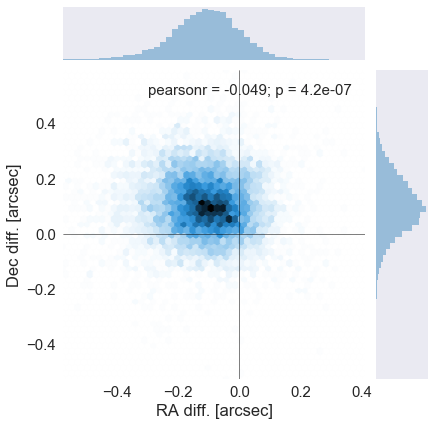

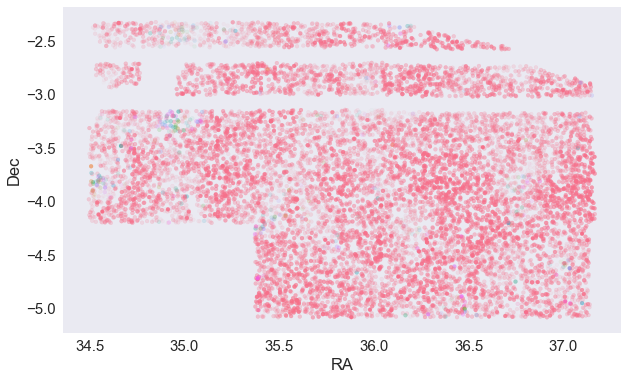

In [11]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [12]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.10588225883907398 arcsec
Dec correction: -0.09947294019285735 arcsec


In [13]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

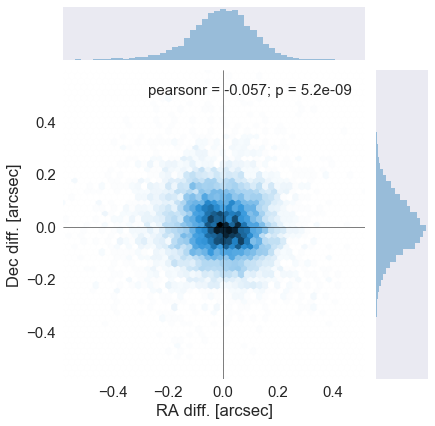

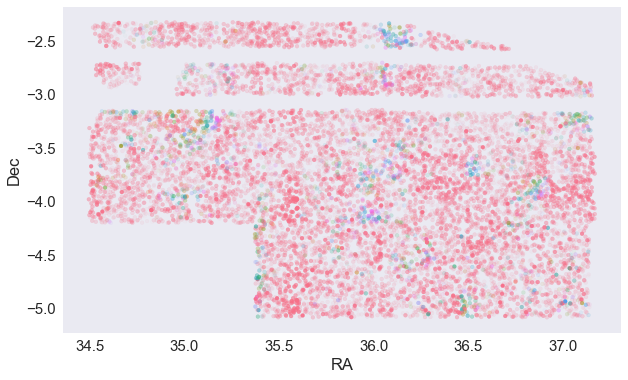

In [14]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [15]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [16]:
GAIA_FLAG_NAME = "dxs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

10794 sources flagged.


# V - Saving to disk

In [17]:
catalogue.write("{}/UKIDSS-DXS.fits".format(OUT_DIR), overwrite=True)